In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UBC-OCEAN/updated_image_ids.json
/kaggle/input/UBC-OCEAN/sample_submission.csv
/kaggle/input/UBC-OCEAN/train.csv
/kaggle/input/UBC-OCEAN/test.csv
/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png
/kaggle/input/UBC-OCEAN/train_images/14127.png
/kaggle/input/UBC-OCEAN/train_images/34649.png
/kaggle/input/UBC-OCEAN/train_images/15221.png
/kaggle/input/UBC-OCEAN/train_images/52375.png
/kaggle/input/UBC-OCEAN/train_images/17487.png
/kaggle/input/UBC-OCEAN/train_images/32112.png
/kaggle/input/UBC-OCEAN/train_images/22290.png
/kaggle/input/UBC-OCEAN/train_images/48734.png
/kaggle/input/UBC-OCEAN/train_images/39146.png
/kaggle/input/UBC-OCEAN/train_images/64950.png
/kaggle/input/UBC-OCEAN/train_images/32042.png
/kaggle/input/UBC-OCEAN/train_images/63429.png
/kaggle/input/UBC-OCEAN/train_images/13526.png
/kaggle/input/UBC-OCEAN/train_images/53859.png
/kaggle/input/UBC-OCEAN/train_images/63836.png
/kaggle/input/UBC-OCEAN/train_images/56117.png
/kaggle/input/UBC-OCEAN/train_i

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-image

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import os
import seaborn as sns
import cv2
import random
import os
import glob
import imageio

In [5]:
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
train_df.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


데이터의 각 feature는 다음과 같은 의미를 가지고 있습니다.(Dataset Description에서 제공)

**image_id** : 각 이미지 고유의 ID코드<br>
**image_width** : 픽셀 단위의 이미지 너비<br>
**image_height** : 픽셀 단위의 이미지 높이<br>
**is_tma** : 단면이 조직 마이크로어레이인 경우 참이며 트레이 세트에만 사용 가능<br>
**label** : 대상 클래스이며 훈련 세트에서만 사용가능<br>
>- **HGSC**(high-grade serous carcinoma) : 고등급 장액성 암종<br>
>- **CC**(clear-cell ovarian carcinoma) : 투명 세포 난소암종<br>
>- **EC**(endometrioid) : 자궁 내막암<br>
>- **LGSC**(low-grade serous carcinoma) : 저등급 장액성 암종<br>
>- **MC**(mucinous carninoma) : 점액성 암종<br>

HGSC,LGSC : 급속한 증식으로 조직괴사와 출혈이 특징.특이적으로 CA-125(cancer antigen-125)를 분비해 진단 시 도움 <br>
CC : 매우 희귀한 종양. 구별이 힘든 경우가 많으며, 세포질 내에 투명한 물질이 가득 차 있는 것이 특징 <br>
EC : 두꺼운 피막으로 둘러싸여 있으며 단면에 연홍색 출혈이 관찰됨 <br>



In [6]:
train_df["label"].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

In [7]:
print(train_df.shape)
print(train_df["label"].value_counts().sum())

(538, 5)
538


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      538 non-null    int64 
 1   label         538 non-null    object
 2   image_width   538 non-null    int64 
 3   image_height  538 non-null    int64 
 4   is_tma        538 non-null    bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 17.5+ KB


In [9]:
print(train_df.isna().sum())
print("결측치 개수는 :",train_df.isna().sum().sum(),"개입니다")

image_id        0
label           0
image_width     0
image_height    0
is_tma          0
dtype: int64
결측치 개수는 : 0 개입니다


In [10]:
print(train_df.image_id.is_unique)
print(train_df.label.is_unique)
print(train_df.image_width.is_unique)
print(train_df.image_height.is_unique)
print(train_df.is_tma.is_unique)

True
False
False
False
False


In [11]:
train_df.head(3)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True


In [12]:
print(train_df["label"])
print(train_df.shape)

0      HGSC
1      LGSC
2      HGSC
3      LGSC
4        EC
       ... 
533    LGSC
534      MC
535    HGSC
536    HGSC
537    HGSC
Name: label, Length: 538, dtype: object
(538, 5)


In [13]:
train_df[["image_width","image_height"]].describe()

,image_width,image_height
count,538.000000,538.000000
mean,48859.533457,29729.460967
std,20040.989927,10762.899796
min,2964.000000,2964.000000
25%,34509.000000,22089.500000
50%,48160.000000,29732.000000
75%,64143.750000,37880.750000
max,105763.000000,50155.000000


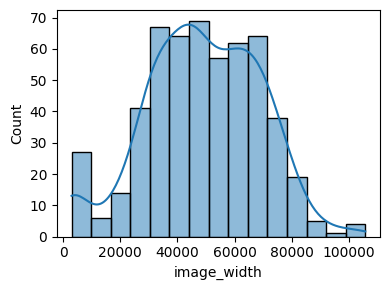

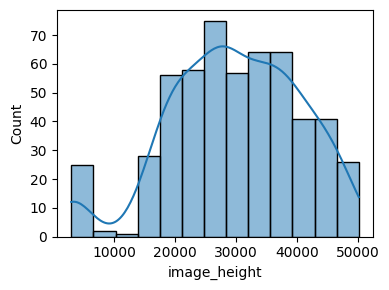

In [14]:
image_col = ["image_width","image_height"]
for col in image_col:
    fig,ax = plt.subplots(figsize=(4,3))
    sns.histplot(data=train_df,x=col,kde=True,ax=ax)
    plt.tight_layout()
    plt.show()

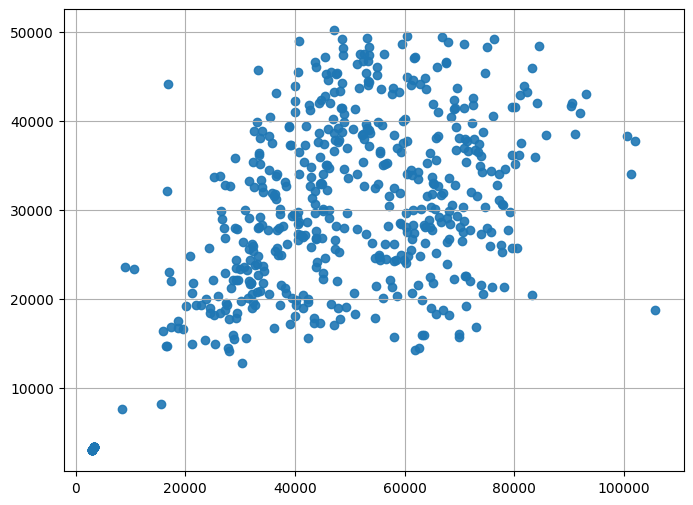

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(train_df["image_width"],train_df['image_height'],alpha=0.9)
plt.grid(True)
plt.show()

In [16]:
HGSC = train_df[train_df['label']=="HGSC"]
EC = train_df[train_df['label']=="EC"]
CC = train_df[train_df['label']=="CC"]
LGSC = train_df[train_df['label']=="LGSC"]
MC = train_df[train_df['label']=="MC"]

In [17]:
HGSC.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
2,91,HGSC,3388,3388,True
5,431,HGSC,39991,40943,False
6,706,HGSC,75606,25965,False
7,970,HGSC,32131,18935,False


In [18]:
HGSC.sort_values(by='image_id', ascending=True)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
2,91,HGSC,3388,3388,True
5,431,HGSC,39991,40943,False
6,706,HGSC,75606,25965,False
7,970,HGSC,32131,18935,False
...,...,...,...,...,...
529,64629,HGSC,25480,14920,False
532,64950,HGSC,70968,37971,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [19]:
HGSC_ratio = round(len(HGSC)/len(train_df),2)
EC_ratio = round(len(EC)/len(train_df),2)
CC_ratio = round(len(CC)/len(train_df),2)
LGSC_ratio = round(len(LGSC)/len(train_df),2)
MC_ratio = round(len(MC)/len(train_df),2)
total_ratio = HGSC_ratio+EC_ratio+CC_ratio+LGSC_ratio+MC_ratio
print("전체 비율은",total_ratio,"입니다")
print("HGSC의 비율은",HGSC_ratio,"입니다.")
print("EC의 비율은",EC_ratio,"입니다.")
print("CC의 비율은",CC_ratio,"입니다.")
print("LGSC의 비율은",LGSC_ratio,"입니다.")
print("MC의 비율은",MC_ratio,"입니다.")

전체 비율은 1.0 입니다
HGSC의 비율은 0.41 입니다.
EC의 비율은 0.23 입니다.
CC의 비율은 0.18 입니다.
LGSC의 비율은 0.09 입니다.
MC의 비율은 0.09 입니다.


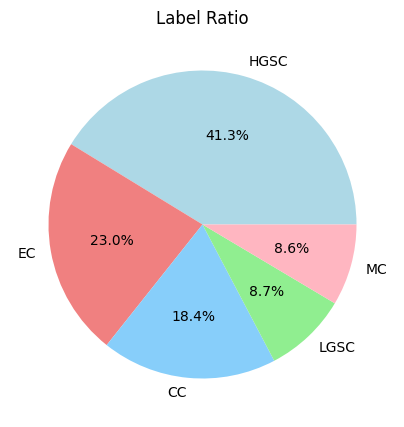

In [20]:
labels =["HGSC","EC","CC","LGSC","MC"]

colors= ["lightblue","lightcoral","lightskyblue",
        "lightgreen","lightpink"]

plt.figure(figsize=(5,5))
plt.pie([len(HGSC),len(EC),len(CC),len(LGSC),len(MC)],
       labels=labels,autopct="%1.1f%%",colors=colors)
plt.title("Label Ratio")
plt.show()

In [21]:
train_data = glob.glob('/kaggle/input/UBC-OCEAN/train_images/*.png')
test_data = glob.glob('/kaggle/input/UBC-OCEAN/test_images/*.png')
print(len(train_data))
print(len(test_data))

538
1


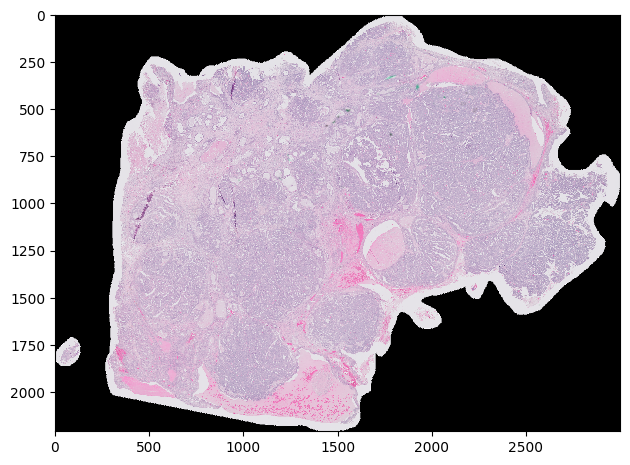

In [22]:
io.imshow("/kaggle/input/UBC-OCEAN/train_thumbnails/10077_thumbnail.png")

In [23]:
io.imshow("/kaggle/input/UBC-OCEAN/test_images/41.png")

DecompressionBombError: Image size (483602903 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [ ]:
labels = ['HGSC', 'LGSC', 'EC', 'CC', 'MC']
for lab in labels:
    imgs_with_label = train_df[train_df.label==lab]
    img_ids = list(imgs_with_label[imgs_with_label.is_tma==True].image_id)
    figure = plt.figure(figsize = (20,6))
    i = 0
    for img_id in img_ids:
        ax = figure.add_subplot(1,5,i+1)
        try:
            io.imshow(f'/kaggle/input/UBC-OCEAN/train_images/{img_id}.png')
            ax.set_title(f'Image Id:{img_id}, label:{lab}', fontsize=14)
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                            bottom=False, left=False, right=False, top=False)
            i= i+1
        except:
            print(f'Thumbnail #{img_id}가 존재하지 않는다.')
plt.show()

In [ ]:
labels = ['HGSC', 'LGSC', 'EC', 'CC', 'MC']
for lab in labels:
    imgs_with_label = train_df[train_df.label==lab]
    img_ids = list(imgs_with_label[imgs_with_label.is_tma==False].image_id.sample(5))
    figure = plt.figure(figsize = (20,6))
    i = 0
    for img_id in img_ids:
        ax = figure.add_subplot(1,5,i+1)
        try:
            io.imshow(f'/kaggle/input/UBC-OCEAN/train_thumbnails/{img_id}_thumbnail.png')
            ax.set_title(f'Image Id:{img_id}, label:{lab}', fontsize=14)
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                            bottom=False, left=False, right=False, top=False)
            i= i+1
        except:
            print(f'Thumbnail #{img_id} does not exist.')
plt.show()

# 간단한 데이터 EDA 확인
https://www.kaggle.com/code/stpeteishii/ovarian-cancer-cropped-data-pytorch-lightnng <br>
https://www.kaggle.com/code/motono0223/ubc-infer-efficientnetb0-crop-resize-2048pix <br>
https://www.kaggle.com/code/rishavsanson/ubc-ocean-ovarian-cancer-efficientnetb0 <br>
https://www.kaggle.com/code/jirkaborovec/cancer-subtype-lightning-torch-inference-tiles <br>

thumbnail과 image에 대한 분석 더 필요<br>
is_tma에 대한 분석 필요<br>
is_tma와 label에 대한 인코딩 필요<br>
image_width,image_height에 대한 이미지 처리 필요<br>

무엇보다 난소암에 대한 도메인 분석 필요<br>
HGSC가 비율이 많은데 데이터 불균형 처리가 필요한가? 우선 진행<br>
어떤 모델이 제일 적당할까?

In [ ]:
train_df["is_tma"].value_counts()

In [ ]:
tma_true = train_df[train_df["is_tma"]==True]
tma_true.head()

is_tma가 True인 것들은 thumbnail이 존재하지 않는다 <br>

In [ ]:
io.imshow("/kaggle/input/UBC-OCEAN/train_images/4134.png")